# 03 Time series

In this notebook we use traditional time series approaches.

## Reading data

We read the datasets from the csv files.

In [94]:
# Basic packages
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

# Catboost
import catboost
from catboost import CatBoostRegressor
from catboost import Pool

# XGBoost
from xgboost import XGBRegressor
from xgboost import plot_importance

# Random Forest
from sklearn.ensemble import RandomForestRegressor

# Linear regression
from sklearn.linear_model import LinearRegression

# Linear SVR
from sklearn.svm import LinearSVR

# Utils
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error

In [95]:
sales = pd.read_csv('data/sales_train.csv', parse_dates=['date'], dtype={
    'date': 'str', 'date_block_num': 'int32', 'shop_id': 'int32', 'item_id': 'int32',
    'item_price': 'float32', 'item_cnt_day': 'int32'
})

test = pd.read_csv('data/test.csv', dtype={'ID': 'int32', 'shop_id': 'int32', 'item_id': 'int32'})

In [96]:
subset = False

if subset:
    shop_ids = [2, 7]
    item_ids = [4897, 7220]
    sales = sales.query('shop_id == @shop_ids and item_id == @item_ids')

In [97]:
# We keep only shops and items present in the test dataset
test_shop_ids = test['shop_id'].unique()
test_item_ids = test['item_id'].unique()

sales = sales[sales['shop_id'].isin(test_shop_ids)]
sales = sales[sales['item_id'].isin(test_item_ids)]

In [98]:
# Aggregate data per month
monthly_sales = sales.sort_values('date').groupby(['date_block_num', 'shop_id', 'item_id'], as_index=False)
monthly_sales = monthly_sales.agg({'item_price': ['sum', 'mean'], 'item_cnt_day': ['sum', 'mean','count']})

# And rename the columns
monthly_sales.columns = ['date_block_num', 'shop_id', 'item_id', 'item_price', 'mean_item_price', 'item_cnt', 'mean_item_cnt', 'transactions']

In [99]:
n_months = 34
date_block_nums = range(n_months)

shop_ids = monthly_sales['shop_id'].unique()

full_sales = []
for date_block_num in date_block_nums:
    for shop_id in shop_ids:
        shop_monthly_sales = monthly_sales[monthly_sales['shop_id'] == shop_id]

        item_ids = shop_monthly_sales['item_id'].unique()
        for item_id in item_ids:
            full_sales.append([date_block_num, shop_id, item_id])

full_sales = pd.DataFrame(full_sales, columns=['date_block_num', 'shop_id', 'item_id'])

In [100]:
monthly_sales = pd.merge(full_sales, monthly_sales, on=['date_block_num','shop_id','item_id'], how='left').fillna(0)

In [101]:
monthly_sales = monthly_sales.sort_values(by=['shop_id', 'item_id', 'date_block_num'])

In [102]:
monthly_sales['year'] = 2013 + monthly_sales['date_block_num'] // 12
monthly_sales['month'] = monthly_sales['date_block_num'] % 12

In [103]:
gp_month_mean = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].mean()
gp_month_sum = monthly_sales.groupby(['month'], as_index=False)['item_cnt'].sum()
gp_shop_mean = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].mean()
gp_shop_sum = monthly_sales.groupby(['shop_id'], as_index=False)['item_cnt'].sum()

Text(0.5, 1.0, 'Montly sum')

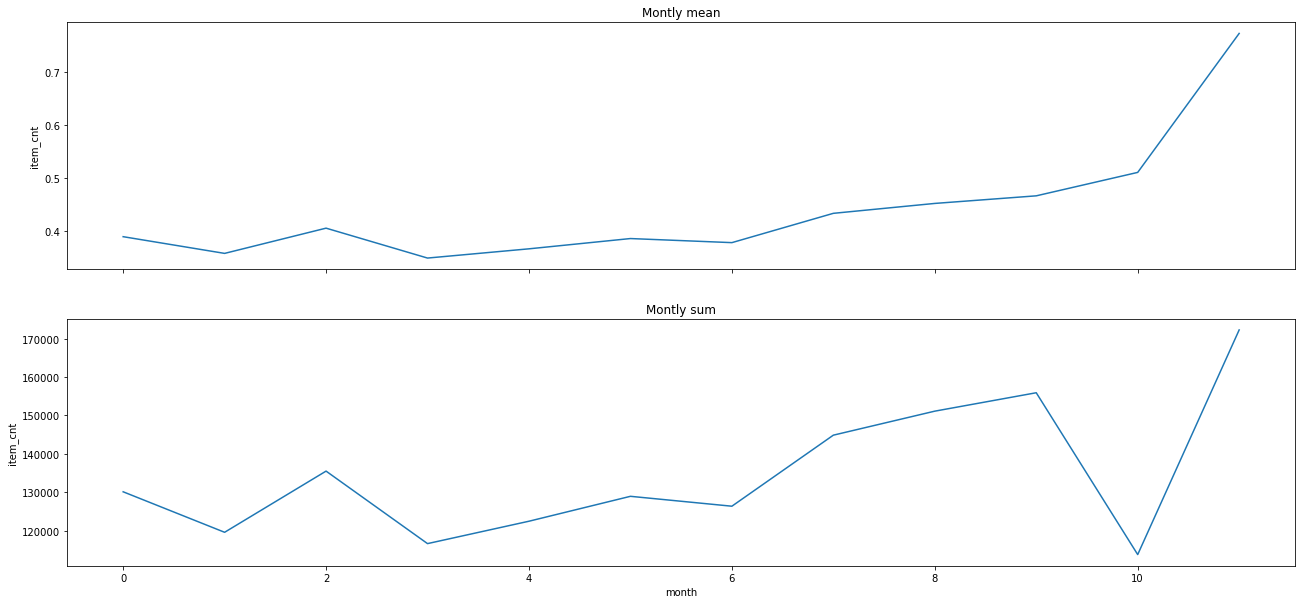

In [104]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.lineplot(x="month", y="item_cnt", data=gp_month_mean, ax=axs[0]).set_title('Montly mean')
sns.lineplot(x="month", y="item_cnt", data=gp_month_sum, ax=axs[1]).set_title('Montly sum')

Text(0.5, 1.0, 'Montly sum')

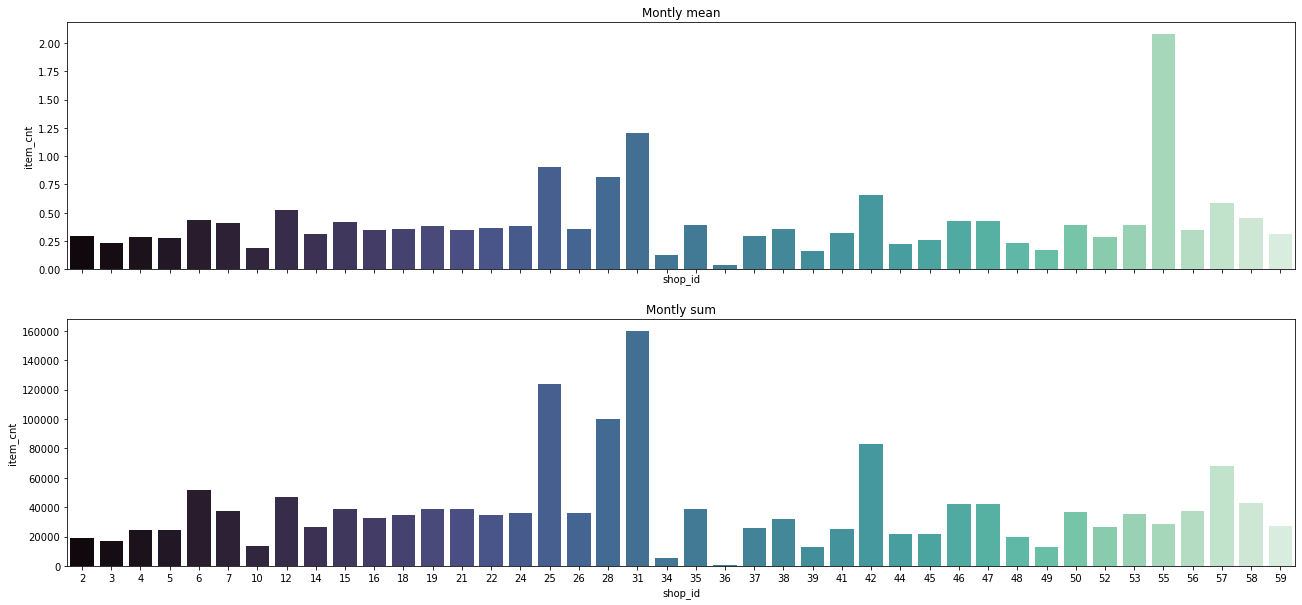

In [105]:
fig, axs = plt.subplots(2, 1, figsize=(22, 10), sharex=True)
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_mean, ax=axs[0], palette='mako').set_title('Montly mean')
sns.barplot(x="shop_id", y="item_cnt", data=gp_shop_sum, ax=axs[1], palette='mako').set_title('Montly sum')

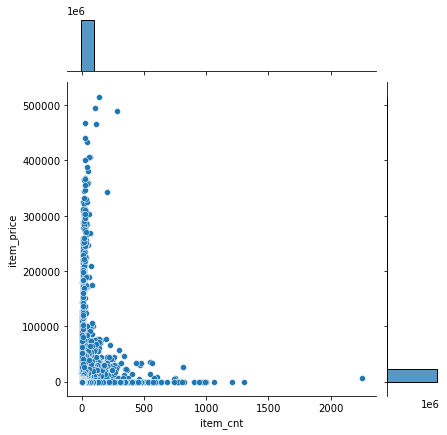

In [106]:
sns.jointplot(x='item_cnt', y='item_price', data=monthly_sales)

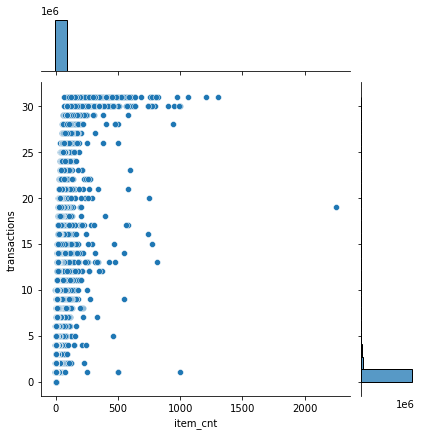

In [107]:
sns.jointplot(x='item_cnt', y='transactions', data=monthly_sales)

In [108]:
# Remove outliers
monthly_sales = monthly_sales[monthly_sales['item_cnt'] >= 0]
monthly_sales = monthly_sales[monthly_sales['item_cnt'] <= 20]
monthly_sales = monthly_sales[monthly_sales['item_price'] <= 400000]

In [109]:
# Response variable
monthly_sales['item_cnt_next_month'] = monthly_sales.groupby(['shop_id', 'item_id'])['item_cnt'].shift(-1)

# Item price per unit
monthly_sales['item_price_unit'] = monthly_sales['item_price'] / monthly_sales['item_cnt']
monthly_sales['item_price_unit'] = monthly_sales['item_price_unit'].fillna(0).replace([np.inf, -np.inf], 0)

In [110]:
gp_item_price = monthly_sales.groupby(['item_id'], as_index=False).agg({'item_price': ['min', 'max']})
gp_item_price.columns = ['item_id', 'hist_min_item_price', 'hist_max_item_price']

In [111]:
monthly_sales = pd.merge(monthly_sales, gp_item_price, on=['item_id'], how='left')

# Price differences from historical min/max
monthly_sales['price_increase'] = monthly_sales['item_price'] - monthly_sales['hist_min_item_price']
monthly_sales['price_decrease'] = monthly_sales['hist_max_item_price'] - monthly_sales['item_price']

In [112]:
# Rolling window based features
window = 3

gp_monthly_sales = monthly_sales.groupby(['shop_id', 'item_id'])

# Actual value of last 3 months
for i in range(1, window + 1):
    monthly_sales['item_cnt_prev_month_' + str(i)] = gp_monthly_sales['item_cnt'].shift(i).fillna(0)

In [113]:
shifted = monthly_sales[[col for col in monthly_sales if col.startswith('item_cnt_prev_month')]]

# Min, max, mean and std of last 3 months
monthly_sales['item_cnt_prev_min'] = shifted.min(axis=1)
monthly_sales['item_cnt_prev_max'] = shifted.max(axis=1)
monthly_sales['item_cnt_prev_mean'] = shifted.mean(axis=1)
monthly_sales['item_cnt_prev_std'] = shifted.std(axis=1)

In [114]:
# Item trend with respect to last 3 months
monthly_sales['item_trend'] = monthly_sales['item_cnt'] - monthly_sales['item_cnt_prev_mean']

## Splitting Train-Validation-Test

In [115]:
# Train set: Months 3 to 27 (drop 0 to 2 as we use 3-month window)
train_set = monthly_sales[(monthly_sales['date_block_num'] >= 3) & (monthly_sales['date_block_num'] < 28)].dropna().copy()
# Validation set: Months 28 to 32
validation_set = monthly_sales[(monthly_sales['date_block_num'] >= 28) & (monthly_sales['date_block_num'] < 33)].dropna().copy()
# Test set: Month 33 (last with available data)
test_set = monthly_sales[monthly_sales['date_block_num'] == 33].copy()

train_set_perc = 100 * train_set.shape[0] / monthly_sales.shape[0]
validation_set_perc = 100 * validation_set.shape[0] / monthly_sales.shape[0]
test_set_perc = 100 * test_set.shape[0] / monthly_sales.shape[0]

train_set_perc, validation_set_perc, test_set_perc

(73.51987594032484, 14.705429673512974, 2.940996021056718)

In [116]:
train_set.shape, validation_set.shape, test_set.shape

((2780085, 24), (556072, 24), (111211, 24))

In [117]:
# Shop mean encoding
gp_shop_mean = train_set.groupby(['shop_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_mean.columns = ['shop_mean']
gp_shop_mean = gp_shop_mean.reset_index()

# Item mean encoding
gp_item_mean = train_set.groupby(['item_id']).agg({'item_cnt_next_month': ['mean']})
gp_item_mean.columns = ['item_mean']
gp_item_mean = gp_item_mean.reset_index()

# Shop-item mean encoding
gp_shop_item_mean = train_set.groupby(['shop_id', 'item_id']).agg({'item_cnt_next_month': ['mean']})
gp_shop_item_mean.columns = ['shop_item_mean']
gp_shop_item_mean = gp_shop_item_mean.reset_index()

# Year mean encoding
gp_year_mean = train_set.groupby(['year']).agg({'item_cnt_next_month': ['mean']})
gp_year_mean.columns = ['year_mean']
gp_year_mean = gp_year_mean.reset_index()

# Month mean encoding
gp_month_mean = train_set.groupby(['month']).agg({'item_cnt_next_month': ['mean']})
gp_month_mean.columns = ['month_mean']
gp_month_mean = gp_month_mean.reset_index()

# Add mean encodings to train and validation set
train_set = pd.merge(train_set, gp_shop_mean, on=['shop_id'], how='left')
train_set = pd.merge(train_set, gp_item_mean, on=['item_id'], how='left')
train_set = pd.merge(train_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
train_set = pd.merge(train_set, gp_year_mean, on=['year'], how='left')
train_set = pd.merge(train_set, gp_month_mean, on=['month'], how='left')

validation_set = pd.merge(validation_set, gp_shop_mean, on=['shop_id'], how='left')
validation_set = pd.merge(validation_set, gp_item_mean, on=['item_id'], how='left')
validation_set = pd.merge(validation_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
validation_set = pd.merge(validation_set, gp_year_mean, on=['year'], how='left')
validation_set = pd.merge(validation_set, gp_month_mean, on=['month'], how='left')

test_set = pd.merge(test_set, gp_shop_mean, on=['shop_id'], how='left')
test_set = pd.merge(test_set, gp_item_mean, on=['item_id'], how='left')
test_set = pd.merge(test_set, gp_shop_item_mean, on=['shop_id', 'item_id'], how='left')
test_set = pd.merge(test_set, gp_year_mean, on=['year'], how='left')
test_set = pd.merge(test_set, gp_month_mean, on=['month'], how='left')

test_set = test_set.drop('item_cnt_next_month', axis=1)

In [118]:
train_set[train_set.isna().any(axis=1)]

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean


In [119]:
validation_set[validation_set.isna().any(axis=1)]

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
555601,32,59,20949,60.0,5.0,18.0,1.5,12.0,2015,8,...,0.0,0.0,0.0,0.0,18.0,0.264746,3.54491,NaN,0.400278,0.297374


In [120]:
test_set[test_set.isna().any(axis=1)]

,date_block_num,shop_id,item_id,item_price,mean_item_price,item_cnt,mean_item_cnt,transactions,year,month,...,item_cnt_prev_min,item_cnt_prev_max,item_cnt_prev_mean,item_cnt_prev_std,item_trend,shop_mean,item_mean,shop_item_mean,year_mean,month_mean
111116,33,59,20949,75.0,5.0,19.0,1.266667,15.0,2015,9,...,0.0,18.0,6.0,10.392305,13.0,0.264746,3.54491,NaN,0.400278,0.349579


In [121]:
validation_set = validation_set.fillna(0)
test_set = test_set.fillna(0)

In [122]:
train_set.shape, validation_set.shape, test_set.shape

((2780085, 29), (556072, 29), (111211, 28))

In [123]:
X_train = train_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_train = train_set['item_cnt_next_month'].astype(int)

X_validation = validation_set.drop(['date_block_num', 'item_cnt_next_month'], axis=1)
y_validation = validation_set['item_cnt_next_month'].astype(int)

X_test = test_set.drop(['date_block_num'], axis=1)

In [124]:
int_features = ['shop_id', 'item_id', 'year', 'month']

X_train[int_features] = X_train[int_features].astype('int32')
X_validation[int_features] = X_validation[int_features].astype('int32')
X_test[int_features] = X_test[int_features].astype('int32')

In [125]:
X_train.shape, y_train.shape, X_validation.shape, y_validation.shape, X_test.shape

((2780085, 27), (2780085,), (556072, 27), (556072,), (111211, 27))

## Catboost

In [126]:
# Specify indices for categorical features: shop_id, item_id, year and month
cat_features = [0, 1, 7, 8]

catboost_model = CatBoostRegressor(
    iterations=500,
    max_ctr_complexity=4,
    random_seed=0,
    od_type='Iter',
    od_wait=25,
    verbose=50,
    depth=4
)

catboost_model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation)
)

Learning rate set to 0.269924
0:	learn: 1.1077558	test: 1.1425111	best: 1.1425111 (0)	total: 2.66s	remaining: 22m 8s
Stopped by overfitting detector  (25 iterations wait)

bestTest = 1.0670471
bestIteration = 12

Shrink model to first 13 iterations.


In [127]:
feature_scores = catboost_model.get_feature_importance(Pool(X_train, label=y_train, cat_features=cat_features))
feature_scores = pd.DataFrame({'Feature': X_train.dtypes.index, 'Score': feature_scores})
feature_scores = feature_scores.sort_values(by='Score', ascending=False)

feature_scores

,Feature,Score
24,shop_item_mean,43.241481
4,item_cnt,36.472285
19,item_cnt_prev_mean,5.026731
26,month_mean,4.078490
14,item_cnt_prev_month_1,2.251639
3,mean_item_price,2.028556
7,year,1.631775
18,item_cnt_prev_max,1.514580
2,item_price,1.447484
16,item_cnt_prev_month_3,0.637018


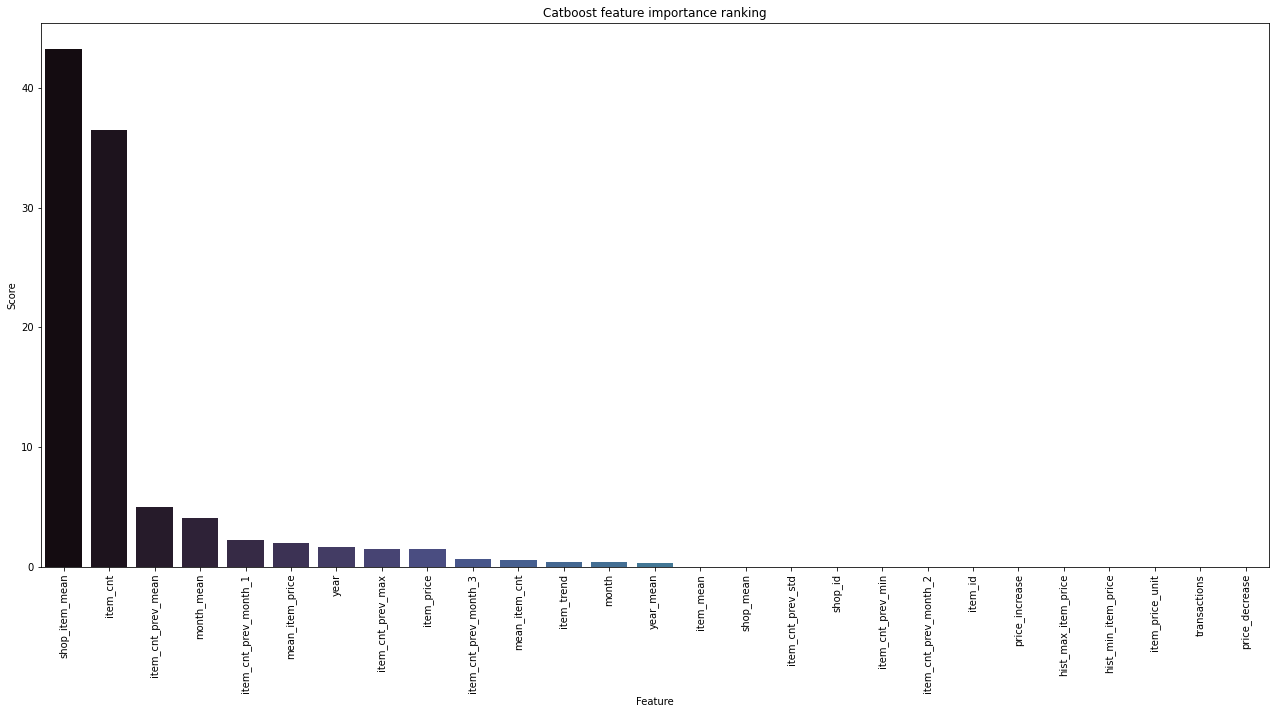

In [128]:
fig, ax = plt.subplots(figsize=(22, 10))
sns.barplot(x="Feature", y="Score", data=feature_scores, ax=ax, palette='mako').set_title('Catboost feature importance ranking')
ax.tick_params(axis='x', rotation=90)

In [129]:
catboost_train_pred = catboost_model.predict(X_train)
catboost_val_pred = catboost_model.predict(X_validation)
catboost_test_pred = catboost_model.predict(X_test)

In [130]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, catboost_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, catboost_val_pred)))

Train rmse: 0.9006610610690245
Validation rmse: 1.0670470996498544


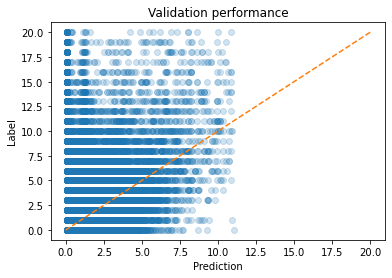

In [131]:
def plot_model_performance(predictions, labels, title):
    # Create DataFrame with predictions and true labels
    performances = pd.DataFrame({'Prediction': predictions, 'Label': labels})

    # Get min and max values of predictions and labels
    min_val = max(max(predictions), max(labels))
    max_val = min(min(predictions), min(labels))

    # Plot data
    fig, ax = plt.subplots()
    ax.scatter(x='Prediction', y='Label', data=performances, color='tab:blue', alpha=0.2)
    ax.plot([min_val, max_val], [min_val, max_val], color='tab:orange', linestyle='--')
    ax.set_xlabel('Prediction')
    ax.set_ylabel('Label')
    plt.title(title)

plot_model_performance(catboost_val_pred, y_validation, 'Validation performance')

## XGBoost

In [132]:
# Use only part of features on XGBoost.
xgb_features = ['item_cnt','item_cnt_prev_mean', 'item_cnt_prev_std', 'item_cnt_prev_month_1',
                'item_cnt_prev_month_2', 'item_cnt_prev_month_3', 'shop_mean',
                'shop_item_mean', 'item_trend', 'mean_item_cnt']
xgb_train = X_train[xgb_features]
xgb_val = X_validation[xgb_features]
xgb_test = X_test[xgb_features]

In [133]:
xgb_model = XGBRegressor(max_depth=8,
                         n_estimators=500,
                         min_child_weight=1000,
                         colsample_bytree=0.7,
                         subsample=0.7,
                         eta=0.3,
                         seed=0)
xgb_model.fit(xgb_train,
              y_train,
              eval_metric="rmse",
              eval_set=[(xgb_train, y_train), (xgb_val, y_validation)],
              verbose=20,
              early_stopping_rounds=20)

[0]	validation_0-rmse:1.08221	validation_1-rmse:1.14058
[20]	validation_0-rmse:0.89718	validation_1-rmse:1.09418
[27]	validation_0-rmse:0.89613	validation_1-rmse:1.10067


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, eta=0.3, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=8,
             min_child_weight=1000, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=4, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
             subsample=0.7, tree_method='exact', validate_parameters=1,
             verbosity=None)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

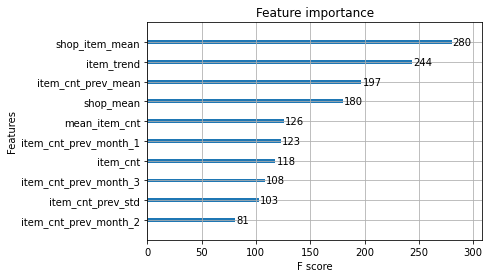

In [134]:
plot_importance(xgb_model)

In [135]:
xgb_train_pred = xgb_model.predict(xgb_train)
xgb_val_pred = xgb_model.predict(xgb_val)
xgb_test_pred = xgb_model.predict(xgb_test)

In [136]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, xgb_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, xgb_val_pred)))

Train rmse: 0.9063084111241146
Validation rmse: 1.0634839415658868


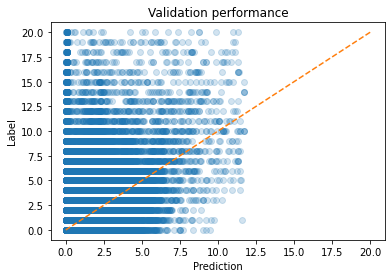

In [137]:
plot_model_performance(xgb_val_pred, y_validation, 'Validation performance')

## Random Forest

In [138]:
rf_features = ['shop_id', 'item_id', 'item_cnt', 'mean_item_cnt', 'transactions', 'year', 'item_cnt_prev_month_1', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_trend', 'shop_mean', 'item_mean']

rf_train = X_train[rf_features]
rf_val = X_validation[rf_features]
rf_test = X_test[rf_features]

In [139]:
rf_model = RandomForestRegressor(n_estimators=50, max_depth=7, random_state=0)
rf_model.fit(rf_train, y_train)

RandomForestRegressor(max_depth=7, n_estimators=50, random_state=0)

In [140]:
rf_train_pred = rf_model.predict(rf_train)
rf_val_pred = rf_model.predict(rf_val)
rf_test_pred = rf_model.predict(rf_test)

In [141]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, rf_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, rf_val_pred)))

Train rmse: 0.9292746392680008
Validation rmse: 1.0297913448953546


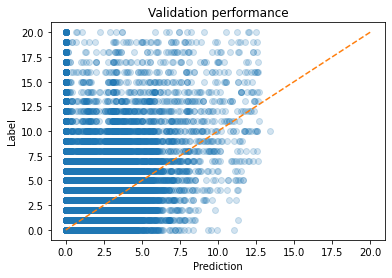

In [142]:
plot_model_performance(rf_val_pred, y_validation, 'Validation performance')

## Linear regression

In [143]:
lr_features = ['item_cnt', 'item_cnt_prev_month_1', 'item_trend', 'mean_item_cnt', 'shop_mean']

lr_train = X_train[lr_features]
lr_val = X_validation[lr_features]
lr_test = X_test[lr_features]

In [144]:
# Normalizing
lr_scaler = MinMaxScaler()
lr_scaler.fit(lr_train)

lr_train = lr_scaler.transform(lr_train)
lr_val = lr_scaler.transform(lr_val)
lr_test = lr_scaler.transform(lr_test)

In [145]:
lr_model = LinearRegression()
lr_model.fit(lr_train, y_train)

LinearRegression()

In [146]:
lr_train_pred = lr_model.predict(lr_train)
lr_val_pred = lr_model.predict(lr_val)
lr_test_pred = lr_model.predict(lr_test)

In [147]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lr_val_pred)))

Train rmse: 0.96557127056507
Validation rmse: 1.0128629563995037


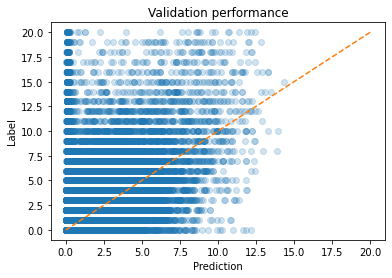

In [148]:
plot_model_performance(lr_val_pred, y_validation, 'Validation performance')

## Linear SVR

In [149]:
lsvr_features = ['item_cnt', 'item_cnt_prev_mean', 'item_cnt_prev_std', 'item_cnt_prev_month_1', 'shop_mean', 'shop_item_mean', 'mean_item_cnt']

lsvr_train = X_train[lsvr_features]
lsvr_val = X_validation[lsvr_features]
lsvr_test = X_test[lsvr_features]

In [150]:
# Normalizing
lsvr_scaler = MinMaxScaler()
lsvr_scaler.fit(lsvr_train)

lsvr_train = lsvr_scaler.transform(lsvr_train)
lsvr_val = lsvr_scaler.transform(lsvr_val)
lsvr_test = lsvr_scaler.transform(lsvr_test)

In [151]:
lsvr_model = LinearSVR()
lsvr_model.fit(lsvr_train, y_train)

LinearSVR(C=1)

In [152]:
lsvr_train_pred = lsvr_model.predict(lsvr_train)
lsvr_val_pred = lsvr_model.predict(lsvr_val)
lsvr_test_pred = lsvr_model.predict(lsvr_test)

In [153]:
print('Train rmse:', np.sqrt(mean_squared_error(y_train, lsvr_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(y_validation, lsvr_val_pred)))

Train rmse: 1.0018868456518795
Validation rmse: 1.053649239114253


## Ensembling

In [154]:
# Validation data becomes the training data for the ensembling step
X_train_ensembling = pd.DataFrame({
    'catboost': catboost_val_pred,
    'xgboost': xgb_val_pred,
    'random_forest': rf_val_pred,
    'linear_regression': lr_val_pred,
    'lsvr': lsvr_val_pred
})

y_train_ensembling = y_validation

In [155]:
# Test data is the test data for the ensembling step
X_test_ensembling = pd.DataFrame({
    'catboost': catboost_test_pred,
    'xgboost': xgb_test_pred,
    'random_forest': rf_test_pred,
    'linear_regression': lr_test_pred,
    'lsvr': lsvr_test_pred
})

In [156]:
ensembling_model = LinearRegression()
ensembling_model.fit(X_train_ensembling, y_train_ensembling)

LinearRegression()

In [157]:
ensemble_train_pred = ensembling_model.predict(X_train_ensembling)
ensemble_test_pred = ensembling_model.predict(X_test_ensembling)

In [158]:
print('Train rmse:', np.sqrt(mean_squared_error(ensemble_train_pred, y_train_ensembling)))

Train rmse: 1.005152328579565


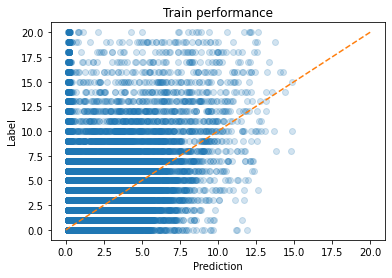

In [159]:
plot_model_performance(ensemble_train_pred, y_train_ensembling, 'Train performance')

## Submission

We finally generate the csv file ready for submission.

In [160]:
def generate_submission_file(data, pred_field, filename='submission.csv'):
    predictions = pd.merge(test, data, on=['shop_id', 'item_id'], how='left').fillna(0)

    output = pd.DataFrame({'ID': predictions['ID'], 'item_cnt_month': predictions[pred_field]})
    output.to_csv('predictions/' + filename, index=False)

In [161]:
X_test['item_cnt_next_month'] = catboost_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'catboost.csv')

X_test['item_cnt_next_month'] = xgb_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'xgboost.csv')

X_test['item_cnt_next_month'] = rf_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'random-forest.csv')

X_test['item_cnt_next_month'] = lr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-regression.csv')

X_test['item_cnt_next_month'] = lsvr_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'linear-svr.csv')

X_test['item_cnt_next_month'] = ensemble_test_pred
generate_submission_file(X_test, 'item_cnt_next_month', 'ensemble.csv')